In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### 1a) les inn og forstå dataene

In [18]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"

df = pd.read_csv(url)

In [19]:
#df.columns
df_select = df[["id", "name", "sex", "age_cat", "race", "two_year_recid", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "is_recid", "is_violent_recid", "v_decile_score", "score_text" ]]

*Hvilke kolonner skal vi velge?*

id, name, sex, dob, age, race, two_year_recid, , juv_fel_count, juv_misd_count, juv_other_count
priors_count, c_charge_degree, is_recid, r_charge_degree, is_violent_recid, v_decile_score, 

Kanskje:
compas_screening_date, days_b_screening_arrest, type_of_assessment 

### Kolonnenes betydning

- **id:** ID-nummer.

- **name:** kandidatens fulle navn.

- **first:** fornavn.

- **last:** etternavn.

- **compas_screening_date:** dato for undersøkelse.

- **sex:** kjønn.

- **dob:** fødselsdato.

- **age:** alder.

- **age_cat:** alderkategori.

- **v_decile_score:**

- **v_score_text:**

- **v_screening_date:**

- **in_custody:** dato for ivaretektsfengsling

- **out_custody:** dato for løslatelse

- **priors_count.1:**

- **start:**

- **end:**

- **event:**

- **two_year_recid:** hvorvidt kandidaten begikk et nytt lovbrudd innen to år

#### 
#### 
- Hvor ofte ulike grupperinger av mennesker (kvinner, menn, hvite og svarte) gjentar forbrytelser og blir predikert til å begå straffbare handlinger i framtiden (som andel, ikke totalt antall):

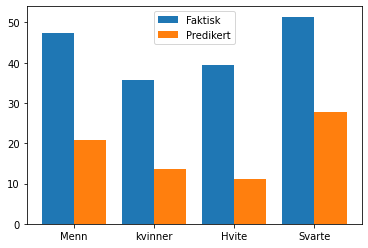

In [20]:
df_male = df_select[df_select["sex"] == "Male"]
df_female = df_select[df_select["sex"] == "Female"]
df_white = df_select[df_select["race"] == "Caucasian"]
df_black = df_select[df_select["race"] == "African-American"]
# two_year_recid


#prosent av gruppen som begår en forbrytelse på nytt innen to år
male_recid = len(df_male[df_male["two_year_recid"]==1].index) / len(df_male.index)*100
female_recid = len(df_female[df_female["two_year_recid"]==1].index) / len(df_female.index)*100
white_recid = len(df_white[df_white["two_year_recid"]==1].index) / len(df_white.index)*100
black_recid = len(df_black[df_black["two_year_recid"]==1].index) / len(df_black.index)*100
"----"
#velger nivå high som at de predikeres til å begå forbrytelese
male_pred = len(df_male[df_male["score_text"] == "High"].index) / len(df_male.index)*100
female_pred = len(df_female[df_female["score_text"] == "High"].index) / len(df_female.index)*100
white_pred = len(df_white[df_white["score_text"] == "High"].index) / len(df_white.index)*100
black_pred = len(df_black[df_black["score_text"] == "High"].index) / len(df_black.index)*100


labels = ["Menn", "kvinner", "Hvite", "Svarte"]
x = np.arange(len(labels))
# y = { "Faktisk" :[male_recid, female_recid, white_recid, black_recid], "Predikert":[male_pred, female_pred, white_pred, black_pred] }

y1 =  [male_recid, female_recid, white_recid, black_recid]
y2 = [male_pred, female_pred, white_pred, black_pred]
width = 0.40

plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.xticks(x, labels)
plt.legend(['Faktisk', 'Predikert'])

#### 
#### 
- Hvor ofte ulike grupper fikk ulike risikoskårer:

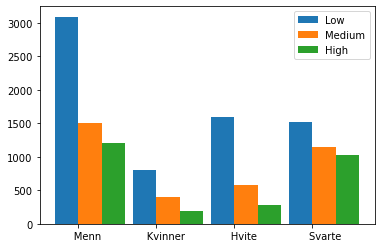

In [21]:
low = [len(df_male[df_male["score_text"] == "Low"].index),
       len(df_female[df_female["score_text"] == "Low"].index),
       len(df_white[df_white["score_text"] == "Low"].index),
       len(df_black[df_black["score_text"] == "Low"].index)]

medium = [len(df_male[df_male["score_text"] == "Medium"].index),
          len(df_female[df_female["score_text"] == "Medium"].index),
          len(df_white[df_white["score_text"] == "Medium"].index),
          len(df_black[df_black["score_text"] == "Medium"].index)]

high = [len(df_male[df_male["score_text"] == "High"].index),
       len(df_female[df_female["score_text"] == "High"].index),
       len(df_white[df_white["score_text"] == "High"].index),
       len(df_black[df_black["score_text"] == "High"].index)]


col_labs = ["Low", "Medium", "High", "h"]
x_labs = ["      Menn", "      Kvinner", "      Hvite" ,"        Svarte"]
x = np.arange(len(col_labs))
width = 0.30

plt.bar(x-0.15, low, width)
plt.bar(x+0.15, medium, width)
plt.bar(x+0.45, high, width)

plt.xticks(x, x_labs)
plt.legend(col_labs)

#### 
#### 
- Hvor ofte de som begikk nye straffbare handlinger (og de som ikke gjorde det) fikk ulike risikoskårer:

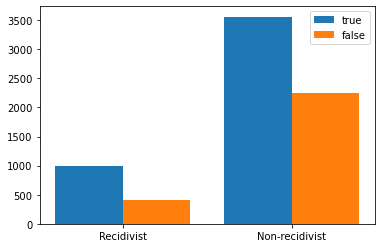

In [22]:
# hvor ofte de som begikk nye straffbare hadlinger (og de som ikke gjorde det) fikk ulike risikoskårer, og hvordan 
# dette ser ut hvis du kun ser på hvite eller svarte.

gold_pos = df_select[df_select["two_year_recid"] == 1]
gold_neg = df_select[df_select["two_year_recid"] == 0]

true_pos = gold_pos[gold_pos["score_text"] == "High"]
false_pos = gold_neg[gold_neg["score_text"] == "High"]

true_neg = gold_neg[gold_neg["score_text"] == "Low"] + gold_neg[gold_neg["score_text"] == "Medium"]
false_neg = gold_pos[gold_pos["score_text"] == "Low"] + gold_pos[gold_pos["score_text"] == "Medium"]

col_labs = ["true", "false"]
x_labs = ["Recidivist", "Non-recidivist"]
x = np.arange(len(col_labs))
width = 0.4

plt.bar(x-0.20, [len(true_pos.index), len(true_neg.index)], width)
plt.bar(x+0.20, [len(false_pos.index), len(false_neg.index)], width)

plt.xticks(x, x_labs)
plt.legend(col_labs)

#### 
#### 
- Hvordan de som begikk nye straffbare handlinger (og de som ikke gjorde det) fikk ulike risikoskårer - hvite versus svarte:

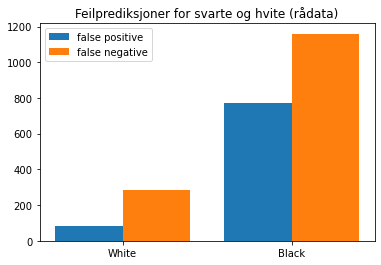

In [23]:
gold_pos_white = gold_pos[gold_pos["race"] == "Caucasian"]
gold_pos_black = gold_pos[gold_pos["race"] == "African-American"]
gold_neg_white = gold_neg[gold_neg["race"] == "Caucasian"]
gold_neg_black = gold_neg[gold_neg["race"] == "African-American"]

false_pos_white = gold_neg_white[gold_neg_white["score_text"] == "High"]
false_pos_black = gold_neg_black[gold_neg_black["score_text"] == "High"]

false_neg_white = gold_pos_white[gold_pos_white["score_text"] == "Low"] + gold_pos_white[gold_pos_white["score_text"] == "Medium"]
false_neg_black = gold_pos_black[gold_pos_black["score_text"] == "Low"] + gold_pos_black[gold_pos_black["score_text"] == "Medium"]

col_labs = ["false positive", "false negative"]
x_labs = ["White", "Black"]
x = np.arange(len(col_labs))
width = 0.4

plt.bar(x-0.2, [len(false_pos_white.index), len(false_neg_white.index)], width)
plt.bar(x+0.2, [len(false_pos_black.index), len(false_neg_black.index)], width)

plt.xticks(x, x_labs)
plt.title("Feilprediksjoner for svarte og hvite (rådata)")
plt.legend(col_labs)

3.3007334963325183
31.41809290953545
7.683982683982683
31.38528138528138


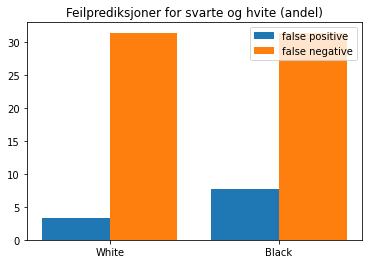

In [24]:
pos_white_ratio = len(false_pos_white.index) / len(df_white.index) * 100
pos_black_ratio = len(false_pos_black.index) / len(df_black.index) * 100
neg_white_ratio = len(false_neg_white.index) / len(df_white.index) * 100
neg_black_ratio = len(false_neg_black.index) / len(df_black.index) * 100

print(pos_white_ratio)
print(neg_white_ratio)
print(pos_black_ratio)
print(neg_black_ratio)

col_labs = ["false positive", "false negative"]
x_labs = ["White", "Black"]
x = np.arange(len(col_labs))
width = 0.4

plt.bar(x-0.2, [pos_white_ratio, pos_black_ratio], width)
plt.bar(x+0.2, [neg_white_ratio, neg_black_ratio], width)

plt.xticks(x, x_labs)
plt.title("Feilprediksjoner for svarte og hvite (andel)")
plt.legend(col_labs)

### 1 d)

In [31]:
# sex', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count'
#print(df_select.sex.unique())
#print(df_select.age_cat.unique())
#print(df_select.race.unique())


print(df_select.juv_misd_count.unique())
print(df_select.juv_other_count.unique())

[ 0  1  6 12  2  4  3  8  5 13]
[ 0  1  2  3  4 17  9  5  6  7]


In [59]:

X_compas = df_select.drop(columns = ['id','name','two_year_recid', "is_violent_recid", "is_recid"])
X_pure = X_compas.drop(columns = ["score_text", "v_decile_score"])

categorical_cols_X_compas = ['sex', 'age_cat', 'race', "score_text"] # skal konverteres til kategoriske vha one-hot encoding
numerical_cols_X_compas = [el for el in X_compas.columns if el not in categorical_cols_X_compas] #skal konverteres til arrays av int

#Konverterer verdier til kategoriske vha one-hot-encoding
X_compas = pd.get_dummies(X_compas, columns=categorical_cols_X_compas, prefix=categorical_cols_X_compas, prefix_sep='_')

categorical_cols_X_pure = ['sex', 'age_cat', 'race']
numerical_cols_X_pure = [el for el in X_pure.columns if el not in categorical_cols_X_pure] #lager en liste av alle som ikke skal være kategoriske

#Konverterer verdier til kategoriske vha one-hot-encoding
X_pure = pd.get_dummies(X_pure, columns=categorical_cols_X_pure, prefix=categorical_cols_X_pure, prefix_sep='_')


#Det som skal predikeres
Y = df_select[["two_year_recid"]]

#konverterer numeriske verdier til numpy-array av int
for col in numerical_cols_X_compas:
    X_compas[col] = X_compas[[col]].to_numpy()

for col in numerical_cols_X_pure:
    X_pure[col] = X_pure[[col]].to_numpy()

    

In [63]:
#Model som predikerer uten COMPAS-data og model som predikerer utifra COMPAS

#logistisk regresjonsmodell

print(Y)
Y = np.ravel(Y)
print(Y)

#Pure
Xp_train, Xp_test, Y_train, Y_test = train_test_split(X_pure, Y, test_size = 0.2, random_state = 0)
log_reg_pure = LogisticRegression()

log_reg_pure.fit(Xp_train, Y_train)

#Compas
Xc_train, X_test, Y_train, Y_test = train_test_split(X_compas, Y, test_size = 0.2, random_state = 0)
log_reg_compas = LogisticRegression()

log_reg_compas.fit(Xc_train, Y_train)





      two_year_recid
0                  0
1                  1
2                  1
3                  0
4                  0
...              ...
7209               0
7210               0
7211               0
7212               0
7213               1

[7214 rows x 1 columns]
[0 1 1 ... 0 0 1]


C:\Users\fartein\Documents\Skole\HON2200\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\fartein\Documents\Skole\HON2200\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

LogisticRegression()

In [ ]:
# plotter "partial dependence"
features = ["priors_count" '''flere parametre her''']

PartialDependenceDisplay.from_estimator('''klassifikator her''', df_select, features)

plt.gcf().set_size_inches(15, 10)
plt.show()